# Music Classification Inference

This notebook demonstrates how to use trained models for music genre prediction on new audio files.

In [1]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Load Model

In [2]:
def load_trained_model(model_class, model_path, n_classes, device='cpu'):
    """Load a trained model."""
    model = model_class(n_classes=n_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from {model_path}")
    return model

## Audio Preprocessing

In [3]:
def preprocess_audio(audio_path, sample_rate=22050, duration=30):
    """Load and preprocess audio file for inference."""
    # Load audio
    waveform, sr = torchaudio.load(audio_path)
    
    # Resample if necessary
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(sr, sample_rate)
        waveform = resampler(waveform)
    
    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Pad or truncate to fixed duration
    target_length = sample_rate * duration
    if waveform.shape[1] > target_length:
        waveform = waveform[:, :target_length]
    elif waveform.shape[1] < target_length:
        padding = target_length - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, padding))
    
    # Add batch dimension
    waveform = waveform.unsqueeze(0)
    
    return waveform

## Single File Prediction (Genre Classification)

In [4]:
def predict_genre(model, audio_path, genre_names, device='cpu', sample_rate=22050, duration=30):
    """Predict genre for a single audio file."""
    # Preprocess audio
    waveform = preprocess_audio(audio_path, sample_rate, duration)
    waveform = waveform.to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(waveform)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_genre = genre_names[predicted.item()]
    confidence_score = confidence.item()
    
    # Get top-k predictions
    top_k = min(5, len(genre_names))
    top_probs, top_indices = torch.topk(probabilities[0], top_k)
    
    print(f"\nPrediction for: {Path(audio_path).name}")
    print(f"Predicted Genre: {predicted_genre}")
    print(f"Confidence: {confidence_score*100:.2f}%")
    print(f"\nTop {top_k} predictions:")
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        print(f"{i+1}. {genre_names[idx.item()]}: {prob.item()*100:.2f}%")
    
    return predicted_genre, confidence_score, probabilities[0].cpu().numpy()

## Multi-label Prediction (Music Tagging)

In [5]:
def predict_tags(model, audio_path, tag_names, device='cpu', sample_rate=22050, 
                 duration=29, threshold=0.5, top_k=10):
    """Predict tags for a single audio file (multi-label)."""
    # Preprocess audio
    waveform = preprocess_audio(audio_path, sample_rate, duration)
    waveform = waveform.to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(waveform)
        probabilities = torch.sigmoid(outputs)
    
    probs = probabilities[0].cpu().numpy()
    
    # Get tags above threshold
    predicted_tags = [(tag_names[i], probs[i]) for i in range(len(tag_names)) 
                      if probs[i] > threshold]
    predicted_tags.sort(key=lambda x: x[1], reverse=True)
    
    # Get top-k tags
    top_tags_indices = np.argsort(probs)[-top_k:][::-1]
    top_tags = [(tag_names[i], probs[i]) for i in top_tags_indices]
    
    print(f"\nPrediction for: {Path(audio_path).name}")
    print(f"\nPredicted tags (threshold={threshold}):")
    if predicted_tags:
        for tag, prob in predicted_tags:
            print(f"  - {tag}: {prob*100:.2f}%")
    else:
        print("  No tags above threshold")
    
    print(f"\nTop {top_k} tags:")
    for i, (tag, prob) in enumerate(top_tags):
        print(f"{i+1}. {tag}: {prob*100:.2f}%")
    
    return predicted_tags, top_tags

## Visualize Predictions

In [6]:
def visualize_prediction(audio_path, probabilities, class_names, sample_rate=22050):
    """Visualize audio and prediction probabilities."""
    # Load audio
    waveform, sr = torchaudio.load(audio_path)
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(sr, sample_rate)
        waveform = resampler(waveform)
    
    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Create mel-spectrogram
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate, n_mels=128
    )
    mel_spec = mel_transform(waveform)
    mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Plot waveform
    axes[0].plot(waveform[0].numpy())
    axes[0].set_title(f'Waveform - {Path(audio_path).name}')
    axes[0].set_xlabel('Sample')
    axes[0].set_ylabel('Amplitude')
    
    # Plot mel-spectrogram
    im = axes[1].imshow(mel_spec_db[0].numpy(), aspect='auto', origin='lower')
    axes[1].set_title('Mel-Spectrogram (dB)')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Mel Frequency')
    plt.colorbar(im, ax=axes[1])
    
    # Plot prediction probabilities
    axes[2].barh(range(len(class_names)), probabilities)
    axes[2].set_yticks(range(len(class_names)))
    axes[2].set_yticklabels(class_names)
    axes[2].set_xlabel('Probability')
    axes[2].set_title('Genre Predictions')
    axes[2].set_xlim([0, 1])
    axes[2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Batch Prediction

In [7]:
def predict_directory(model, directory_path, genre_names, device='cpu', 
                      sample_rate=22050, duration=30):
    """Predict genres for all audio files in a directory."""
    directory = Path(directory_path)
    audio_files = list(directory.glob('*.wav')) + list(directory.glob('*.mp3'))
    
    results = []
    
    print(f"\nProcessing {len(audio_files)} files from {directory_path}")
    print("-" * 70)
    
    for audio_file in audio_files:
        try:
            predicted_genre, confidence, _ = predict_genre(
                model, str(audio_file), genre_names, device, sample_rate, duration
            )
            results.append({
                'file': audio_file.name,
                'genre': predicted_genre,
                'confidence': confidence
            })
        except Exception as e:
            print(f"Error processing {audio_file.name}: {e}")
    
    return results

## Example Usage

### Genre Classification Example

Model module not found; loading from notebook via %run ...
SimpleCNN:
SimpleCNN(
  (mel_spec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (amplitude_to_db): AmplitudeToDB()
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, ke

f:\Code\NLP\Tagging-Music-Sequences\venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
f:\Code\NLP\Tagging-Music-Sequences\venv\Lib\site-packages\torchaudio\functional\functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


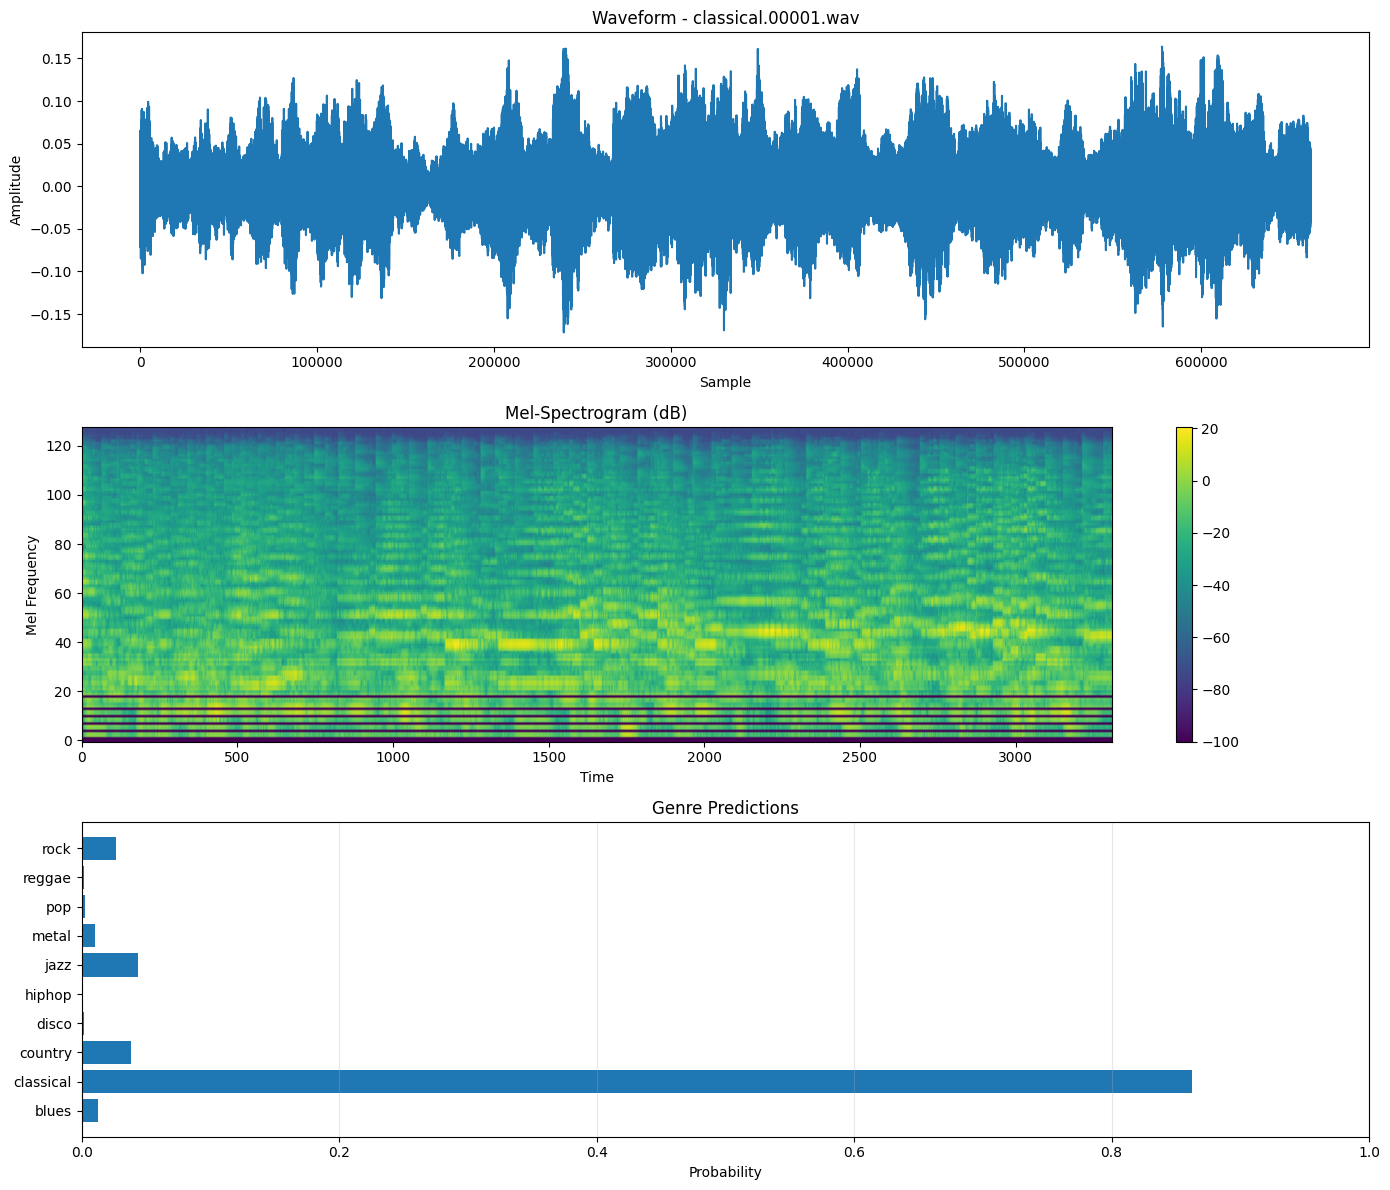

In [ ]:
# GTZAN genre classification

import os
import sys
from pathlib import Path
repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# Import model (prefer module; fallback to notebook)
try:
    from model_cnn import SimpleCNN
except ModuleNotFoundError:
    print("Model module not found; loading from notebook via %run ...")
    %run "./04_model_cnn.ipynb"

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GENRE_NAMES = ['blues', 'classical', 'country', 'disco', 'hiphop', 
               'jazz', 'metal', 'pop', 'reggae', 'rock']

# Load model
model = load_trained_model(
    SimpleCNN, 
    '../models/gtzan_cnn.pth', 
    n_classes=10, 
    device=device
)

# Predict single file
audio_path = '../data/gtzan/country/country.00001.wav'
predicted_genre, confidence, probs = predict_genre(
    model, audio_path, GENRE_NAMES, device
)
# Visualize
visualize_prediction(audio_path, probs, GENRE_NAMES)

### Music Tagging Example

In [ ]:
# Example for MTAT music tagging
# Uncomment and adapt to your setup

# from notebooks.model_cnn import DeepCNN

# # Load model
# TAG_NAMES = ['rock', 'pop', 'alternative', 'indie', ...]  # Your tag list
# model = load_trained_model(
#     DeepCNN,
#     '../models/mtat_cnn.pth',
#     n_classes=50,
#     device=device
# )

# # Predict tags
# audio_path = '../data/test_audio.wav'
# predicted_tags, top_tags = predict_tags(
#     model, audio_path, TAG_NAMES, device, threshold=0.3, top_k=10
# )